### 95-865 k-means, GMM, DP-GMM demo
by George Chen, Fall 2017 instructor

This demo uses the UCI drug consumption dataset:
https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29#

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import csv
import numpy as np
np.set_printoptions(suppress=True)  # somewhat prettier printing

drug_data = []
with open('drug_consumption.data', 'r') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    for row in csv_reader:
        drug_data.append([float(x) for x in row[1:13]])
drug_data = np.array(drug_data)
drug_data.shape

(3770, 12)

(-4.7834497854877434,
 5.246089512309557,
 -4.9663507648067089,
 5.092194624575602)

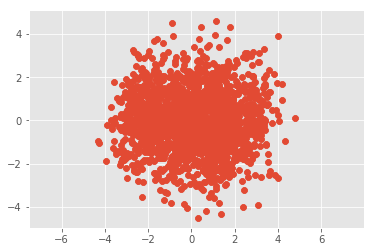

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
drug_data_normalized = scaler.fit_transform(drug_data)  # for each feature, subtract off mean and divide by std dev.
#12->2 dmensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
drug_data_normalized_pca2d = pca.fit_transform(drug_data_normalized)

plt.scatter(drug_data_normalized_pca2d[:, 0], drug_data_normalized_pca2d[:, 1], cmap='Set3')
plt.axis('equal')

In [8]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)  # should actually try different perplexity values!
drug_data_normalized_tsne2d = tsne.fit_transform(drug_data_normalized)

(-130.74112990047769,
 110.02635481502847,
 -104.00308477304891,
 127.16844427011925)

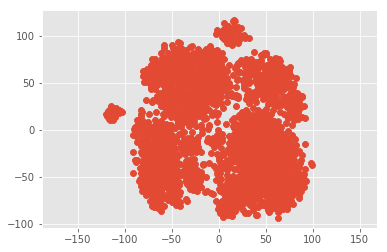

In [9]:
plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1], cmap='Set3')
plt.axis('equal')

(-130.74112990047769,
 110.02635481502847,
 -104.00308477304891,
 127.16844427011925)

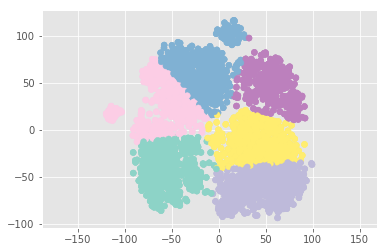

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, n_init=1000, random_state=95865)
kmeans.fit(drug_data_normalized_tsne2d)

 
plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1],
            c=kmeans_cluster_assignments, cmap='Set3')
plt.axis('equal')

In [11]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=6, n_init=200, random_state=95865)
gmm.fit(drug_data_normalized_tsne2d)

print(np.sort(gmm.weights_)[::-1])

[ 0.26406979  0.18455987  0.17586321  0.16120595  0.1422627   0.07203848]


(-130.74112990047769,
 110.02635481502847,
 -104.00308477304891,
 127.16844427011925)

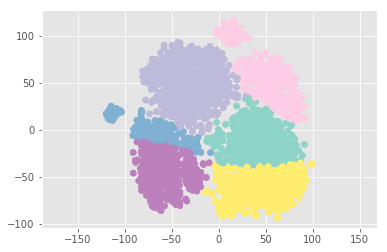

In [12]:
gmm_cluster_assignments = gmm.predict(drug_data_normalized_tsne2d)
plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1], c=gmm_cluster_assignments, cmap='Set3')
plt.axis('equal')

In [27]:
from sklearn.mixture import BayesianGaussianMixture

dpgmm = BayesianGaussianMixture(n_components=20, weight_concentration_prior=.1, n_init=200, random_state=95865)
dpgmm.fit(drug_data_normalized_tsne2d)

print(np.sort(dpgmm.weights_)[::-1])

[ 0.11737188  0.11576499  0.10593015  0.09764283  0.08859472  0.07877089
  0.07360362  0.06561609  0.06353419  0.0561792   0.05289445  0.04599203
  0.03364887  0.00354696  0.00065963  0.00023672  0.00001162  0.00000106
  0.0000001   0.00000001]


C:\Users\Anupam\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 200 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [28]:
dpgmm_cluster_assignments = dpgmm.predict(drug_data_normalized_tsne2d)

(-130.74112990047769,
 110.02635481502847,
 -104.00308477304891,
 127.16844427011925)

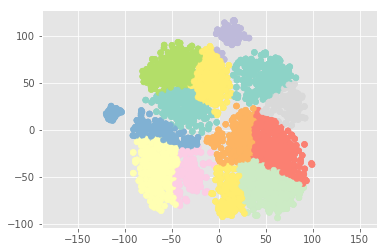

In [29]:
plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1], c=dpgmm_cluster_assignments, cmap='Set3')
plt.axis('equal')

In the next block of code, I copy over only the "top" clusters in the DP-GMM that have a high enough probability of occurring (in this example, I only keep a cluster if its probability of occuring is greater than 0.1).

In [30]:
top_cluster_mask = dpgmm.weights_ > .05
print(top_cluster_mask)

[False  True  True  True False  True  True  True  True  True False False
  True  True  True False False False False False]


In [31]:
# as a technical remark, in the next line of code `dpgmm_precisions_chol` is just a
# variable computed by sklearn's DP-GMM fitting based on the covariance matrices;
# basically you can take a "square root" of a covariance matrix called a Cholesky
# decomposition which turns out to be very useful in many linear algebra problems
# (the math behind Gaussians in more than 1 dimension is all linear algebra)
_, _, dpgmm_means, _, dpgmm_covariances, dpgmm_precisions_chol = dpgmm._get_parameters()

# copy weights, zero out weights for clusters that are too small, and for the
# sufficiently large clusters, renormalize the weights so that they sum to 1
dpgmm_weights_truncated = dpgmm.weights_
dpgmm_weights_truncated[~top_cluster_mask] = 0
dpgmm_weights_truncated /= np.sum(dpgmm_weights_truncated)
dpgmm_weights_truncated

array([ 0.        ,  0.08036181,  0.09672937,  0.12814881,  0.        ,
        0.11565651,  0.06936782,  0.07164087,  0.10660826,  0.06133749,
        0.        ,  0.        ,  0.12639438,  0.05775115,  0.08600353,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [32]:
dpgmm_num_top_clusters = np.sum(top_cluster_mask)
print(dpgmm_num_top_clusters)
dpgmm_weights_truncated[top_cluster_mask]

11


array([ 0.08036181,  0.09672937,  0.12814881,  0.11565651,  0.06936782,
        0.07164087,  0.10660826,  0.06133749,  0.12639438,  0.05775115,
        0.08600353])

In [33]:
gmm_using_top_dpgmm_clusters = GaussianMixture(n_components=dpgmm_num_top_clusters)
gmm_using_top_dpgmm_clusters._set_parameters((dpgmm_weights_truncated[top_cluster_mask],
                                              dpgmm_means[top_cluster_mask],
                                              dpgmm_covariances[top_cluster_mask],
                                              dpgmm_precisions_chol[top_cluster_mask]))

(-130.74112990047769,
 110.02635481502847,
 -104.00308477304891,
 127.16844427011925)

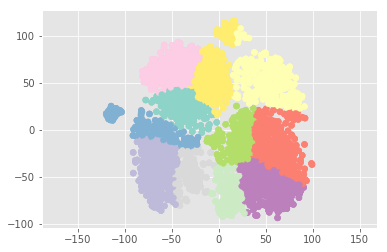

In [34]:
dpgmm_top_clusters_assignment = gmm_using_top_dpgmm_clusters.predict(drug_data_normalized_tsne2d)
plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1], c=dpgmm_top_clusters_assignment, cmap='Set3')
plt.axis('equal')

The result isn't great. You could try with more restarts. Alternatively you could use the DP-GMM to give you a sense of what the number of clusters should be (by looking at how many clusters are "large enough") and then just fitting lots of regular GMM's with that many number of clusters.